In [136]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from tqdm.notebook import tqdm
from itertools import product
import time

**РЕАЛИЗАЦИЯ АЛГОРИТМА ШТРАССЕНА И НАИВНОГО МЕТОДА**
- Реализуйте рекурсивный алгоритм Штрассена и наивного метода для перемножения матриц.

**РЕАЛИЗАЦИЯ МЕТОДА ВРАЩЕНИЙ (ЯКОБИ)**
- Реализуйте итеративный метод Якоби для нахождения собственных значений и векторов симметричной
матрицы.

**ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ**
- Загрузите ссылку на любое изображение из сети Интернет и преобразуйте его в матрицу. Центрируйте данные,
вычтя среднее значение по столбцам.

**ВЫЧИСЛЕНИЕ КОВАРИАЦИОННОЙ МАТРИЦЫ**
- Вычислите ковариационную матрицу для центрированных данных, используя алгоритм Штрассена для
перемножения матриц.

**ПОИСК СОБСТВЕННЫХ ЗНАЧЕНИЙ И ВЕКТОРОВ**
- Примените метод вращений (Якоби), наивный метод к ковариационной матрице для нахождения её
собственных значений и векторов.

**СЖАТИЕ И ВОССТАНОВЛЕНИЕ ИЗОБРАЖЕНИЯ**
- Выполните сжатие изображения, используя различное число главных компонент (k). Затем восстановите
изображение на основе выбранных компонент.

**СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ**
- Измерьте время выполнения вашего кода для метода Якоби, наивного метода. Сравните результаты с
использованием стандартных методов из библиотеки NumPy (np.dot). Объясните полученные результаты.

**ОЦЕНКА КАЧЕСТВА**
- Оцените качество восстановленного изображения, вычислив среднеквадратичную ошибку (MSE) между
оригинальным и восстановленным изображением. Выведите на экране полученных после сжатия по методу
PCA изображения. Выведите их размер в килобайтах. Объясните полученные результаты.

# Наивное умножение матриц

In [137]:
def naive_multiply(A, B):
    n = len(A)
    result = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                result[i][j] += A[i][k] * B[k][j]
    return result

# Вспомогательные функции для алгоритма Штрассена

In [138]:
def next_power_of_two(n):
    """Вычисляет ближайшую степень двойки, не меньше n."""
    return 1 << (n - 1).bit_length()

def pad_matrix(A, size):
    """Дополняет матрицу A нулями до размера (size x size)."""
    padded = np.zeros((size, size), dtype=A.dtype)
    padded[:A.shape[0], :A.shape[1]] = A
    return padded

# Алгоритм Штрассена

In [139]:
from numba import njit

In [140]:
def strassen_multiply(A, B, leaf_size=64):
    """
    Функция для перемножения матриц A и B с использованием алгоритма Штрассена.
    Если размеры матриц не являются степенью двойки, они дополняются нулями до ближайшего такого размера.
    Возвращается матрица размера (A.shape[0] x B.shape[1]).
    """
    assert A.shape[1] == B.shape[0], "Неверные размеры матриц для умножения"
    
    # Определяем новый размер для дополнения (наибольшая сторона среди A и B)
    n = max(A.shape[0], A.shape[1], B.shape[1])
    m = next_power_of_two(n)
    
    A_padded = pad_matrix(A, m)
    B_padded = pad_matrix(B, m)
    C_padded = strassen(A_padded, B_padded, leaf_size)
    
    # Обрезаем матрицу до исходных размеров
    return C_padded[:A.shape[0], :B.shape[1]]

def strassen(A, B, leaf_size=64):
    """
    Рекурсивное перемножение матриц A и B с использованием алгоритма Штрассена.
    
    Параметры:
      A, B: Квадратные матрицы размера n x n (если они не квадратные – их надо дополнить).
      leaf_size: Порог, при котором используется стандартное умножение.
    """
    n = A.shape[0]
    if n <= leaf_size:
        return A @ B
    else:
        mid = n // 2
        
        # Разбиваем матрицы на квадранты
        a11 = A[:mid, :mid]
        a12 = A[:mid, mid:]
        a21 = A[mid:, :mid]
        a22 = A[mid:, mid:]
        
        b11 = B[:mid, :mid]
        b12 = B[:mid, mid:]
        b21 = B[mid:, :mid]
        b22 = B[mid:, mid:]
        
        # Вычисляем 7 произведений по схеме Штрассена
        M1 = strassen(a11 + a22, b11 + b22, leaf_size)
        M2 = strassen(a21 + a22, b11, leaf_size)
        M3 = strassen(a11, b12 - b22, leaf_size)
        M4 = strassen(a22, b21 - b11, leaf_size)
        M5 = strassen(a11 + a12, b22, leaf_size)
        M6 = strassen(a21 - a11, b11 + b12, leaf_size)
        M7 = strassen(a12 - a22, b21 + b22, leaf_size)
        
        # Вычисляем блоки результирующей матрицы
        c11 = M1 + M4 - M5 + M7
        c12 = M3 + M5
        c21 = M2 + M4
        c22 = M1 - M2 + M3 + M6
        
        # Объединяем квадранты
        top = np.hstack((c11, c12))
        bottom = np.hstack((c21, c22))
        C = np.vstack((top, bottom))
        return C
    
    
@njit(nopython=True)
def numba_strassen_multiply(A, B, leaf_size=64):
    """
    Функция для перемножения матриц A и B с использованием алгоритма Штрассена.
    Если размеры матриц не являются степенью двойки, они дополняются нулями до ближайшего такого размера.
    Возвращается матрица размера (A.shape[0] x B.shape[1]).
    """
    assert A.shape[1] == B.shape[0], "Неверные размеры матриц для умножения"
    
    # Определяем новый размер для дополнения (наибольшая сторона среди A и B)
    n = max(A.shape[0], A.shape[1], B.shape[1])
    m = next_power_of_two(n)
    
    A_padded = pad_matrix(A, m)
    B_padded = pad_matrix(B, m)
    C_padded = numba_strassen(A_padded, B_padded, leaf_size)
    
    # Обрезаем матрицу до исходных размеров
    return C_padded[:A.shape[0], :B.shape[1]]

@njit(nopython=True)
def numba_strassen(A, B, leaf_size=64):
    """
    Рекурсивное перемножение матриц A и B с использованием алгоритма Штрассена.
    
    Параметры:
      A, B: Квадратные матрицы размера n x n (если они не квадратные – их надо дополнить).
      leaf_size: Порог, при котором используется стандартное умножение.
    """
    n = A.shape[0]
    if n <= leaf_size:
        return A @ B
    else:
        mid = n // 2
        
        # Разбиваем матрицы на квадранты
        a11 = A[:mid, :mid]
        a12 = A[:mid, mid:]
        a21 = A[mid:, :mid]
        a22 = A[mid:, mid:]
        
        b11 = B[:mid, :mid]
        b12 = B[:mid, mid:]
        b21 = B[mid:, :mid]
        b22 = B[mid:, mid:]
        
        # Вычисляем 7 произведений по схеме Штрассена
        M1 = strassen(a11 + a22, b11 + b22, leaf_size)
        M2 = strassen(a21 + a22, b11, leaf_size)
        M3 = strassen(a11, b12 - b22, leaf_size)
        M4 = strassen(a22, b21 - b11, leaf_size)
        M5 = strassen(a11 + a12, b22, leaf_size)
        M6 = strassen(a21 - a11, b11 + b12, leaf_size)
        M7 = strassen(a12 - a22, b21 + b22, leaf_size)
        
        # Вычисляем блоки результирующей матрицы
        c11 = M1 + M4 - M5 + M7
        c12 = M3 + M5
        c21 = M2 + M4
        c22 = M1 - M2 + M3 + M6
        
        # Объединяем квадранты
        top = np.hstack((c11, c12))
        bottom = np.hstack((c21, c22))
        C = np.vstack((top, bottom))
        return C

c:\ProgramData\anaconda3\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Реализация метода Якоби для собственных значений/векторов

In [141]:
def jacobi_eigen_np(A, tol=1e-10, max_iter=20000):
    A = np.array(A, dtype=np.float64)
    n = A.shape[0]
    V = np.eye(n)
    
    for _ in range(max_iter):
        # Находим максимальный внедиагональный элемент
        off_diag = A - np.diag(np.diag(A))
        i, j = np.unravel_index(np.argmax(np.abs(off_diag)), A.shape)
        max_val = np.abs(A[i, j])
        
        if max_val < tol:
            break
        
        # Вычисляем угол поворота
        if A[i, i] == A[j, j]:
            theta = np.pi/4
        else:
            theta = 0.5 * np.arctan2(2*A[i,j], (A[j,j] - A[i,i]))
        c = np.cos(theta)
        s = np.sin(theta)
        
        # Создаем матрицу поворота Q
        Q = np.eye(n)
        Q[i, i] = c
        Q[j, j] = c
        Q[i, j] = -s
        Q[j, i] = s
        
        # Обновляем A и V по правилу A' = Q^T A Q
        A = Q.T @ A @ Q
        V = V @ Q
    
    eigenvalues = np.diag(A)
    return eigenvalues, V

def jacobi_eigen(A, tol=1e-10, max_iter=20000):
    A = np.array(A, dtype=np.float64)
    n = A.shape[0]
    V = np.eye(n)
    
    # Предварительное кэширование индексов
    indices = np.triu_indices(n, k=1)
    
    for _ in (range(max_iter)):
        # Ускоренный поиск максимального внедиагонального элемента
        triu_abs = np.abs(A[indices])
        max_idx = np.argmax(triu_abs)
        max_val = triu_abs[max_idx]
        
        if max_val < tol:
            break
            
        i, j = indices[0][max_idx], indices[1][max_idx]
        
        # Вычисление угла поворота
        alpha = (A[j,j] - A[i,i]) / (2 * A[i,j])
        t = np.sign(alpha) / (np.abs(alpha) + np.sqrt(1 + alpha**2))
        c = 1 / np.sqrt(1 + t**2)
        s = t * c
        
        # Векторизованное обновление матрицы A
        row_i = A[i, :].copy()
        row_j = A[j, :].copy()
        
        A[i, :] = c*row_i - s*row_j
        A[j, :] = s*row_i + c*row_j
        A[:, i] = A[i, :]
        A[:, j] = A[j, :]
        
        A[i,j] = 0
        A[j,i] = 0
        
        # Обновление собственных векторов
        V_i = V[:, i].copy()
        V_j = V[:, j].copy()
        V[:, i] = c*V_i - s*V_j
        V[:, j] = s*V_i + c*V_j
        
    eigenvalues = np.diag(A)
    return eigenvalues, V


@njit  # Убрано nopython=True, так как njit уже подразумевает этот режим [[1]][[2]]
def numba_jacobi_eigen(A, tol=1e-10, max_iter=20000):
    # Гарантируем, что входная матрица имеет тип float64
    A = A.astype(np.float64)  # Замена np.array на .astype() [[1]]
    n = A.shape[0]
    V = np.eye(n)
    
    for _ in range(max_iter):
        # Поиск максимального внедиагонального элемента без np.triu_indices
        max_val = 0.0
        i_max, j_max = 0, 0
        for i in range(n):
            for j in range(i+1, n):
                current = abs(A[i, j])
                if current > max_val:
                    max_val = current
                    i_max, j_max = i, j
        
        if max_val < tol:
            break
        
        i, j = i_max, j_max
        
        # Вычисление угла поворота
        alpha = (A[j,j] - A[i,i]) / (2 * A[i,j] + 1e-16)  # Защита от деления на ноль
        t = np.sign(alpha) / (np.abs(alpha) + np.sqrt(1 + alpha**2))
        c = 1 / np.sqrt(1 + t**2)
        s = t * c
        
        # Обновление матрицы A
        A_i = A[i, :].copy()
        A_j = A[j, :].copy()
        
        A[i, :] = c*A_i - s*A_j
        A[j, :] = s*A_i + c*A_j
        A[:, i] = A[i, :]
        A[:, j] = A[j, :]
        
        A[i, j] = 0.0
        A[j, i] = 0.0
        
        # Обновление собственных векторов
        V_i = V[:, i].copy()
        V_j = V[:, j].copy()
        V[:, i] = c*V_i - s*V_j
        V[:, j] = s*V_i + c*V_j
        
    eigenvalues = np.diag(A)
    
    return eigenvalues, V

def jacobi_eigen_strassen(A, tol=1e-10, max_iter=20000):
    A = np.array(A, dtype=np.float64)
    n = A.shape[0]
    V = np.eye(n)
    
    for _ in range(max_iter):
        # Находим максимальный внедиагональный элемент
        off_diag = A - np.diag(np.diag(A))
        i, j = np.unravel_index(np.argmax(np.abs(off_diag)), A.shape)
        max_val = np.abs(A[i, j])
        
        if max_val < tol:
            break
        
        # Вычисляем угол поворота
        if A[i, i] == A[j, j]:
            theta = np.pi/4
        else:
            theta = 0.5 * np.arctan2(2*A[i,j], (A[j,j] - A[i,i]))
        c = np.cos(theta)
        s = np.sin(theta)
        
        # Создаем матрицу поворота Q
        Q = np.eye(n)
        Q[i, i] = c
        Q[j, j] = c
        Q[i, j] = -s
        Q[j, i] = s
        
        # Обновляем A и V по правилу A' = Q^T A Q
        A = strassen_multiply(strassen_multiply(Q.T, A), Q)
        V =strassen_multiply(V, Q)
    
    eigenvalues = np.diag(A)
    return eigenvalues, V


@njit(nopython=True)
def numba_jacobi_eigen_strassen(A, tol=1e-10, max_iter=20000):
    A = np.array(A, dtype=np.float64)
    n = A.shape[0]
    V = np.eye(n)
    
    for _ in range(max_iter):
        # Находим максимальный внедиагональный элемент
        off_diag = A - np.diag(np.diag(A))
        i, j = np.unravel_index(np.argmax(np.abs(off_diag)), A.shape)
        max_val = np.abs(A[i, j])
        
        if max_val < tol:
            break
        
        # Вычисляем угол поворота
        if A[i, i] == A[j, j]:
            theta = np.pi/4
        else:
            theta = 0.5 * np.arctan2(2*A[i,j], (A[j,j] - A[i,i]))
        c = np.cos(theta)
        s = np.sin(theta)
        
        # Создаем матрицу поворота Q
        Q = np.eye(n)
        Q[i, i] = c
        Q[j, j] = c
        Q[i, j] = -s
        Q[j, i] = s
        
        # Обновляем A и V по правилу A' = Q^T A Q
        A = numba_strassen_multiply(numba_strassen_multiply(Q.T, A), Q)
        V =numba_strassen_multiply(V, Q)
    
    eigenvalues = np.diag(A)
    return eigenvalues, V

# Функция сжатия и восстановления

In [142]:
def compress_and_reconstruct_strassen(X_centered, X_mean, eigenvectors_sorted, components):    
    projected_data = strassen_multiply(X_centered, eigenvectors_sorted[:, :components])
    reconstructed_data = strassen_multiply(projected_data, eigenvectors_sorted[:, :components].T)
    return projected_data, np.clip(reconstructed_data + X_mean, 0, 1)  # Ограничение значений [0,1]

def compress_and_reconstruct_np(X_centered, X_mean, eigenvectors_sorted, components):    
    projected_data = np.dot(X_centered, eigenvectors_sorted[:, :components])
    reconstructed_data = np.dot(projected_data, eigenvectors_sorted[:, :components].T)
    return projected_data, np.clip(reconstructed_data + X_mean, 0, 1)  # Ограничение значений [0,1]

@njit(nopython=True)
def numba_compress_and_reconstruct_strassen(X_centered, X_mean, eigenvectors_sorted, components):    
    projected_data = strassen_multiply(X_centered, eigenvectors_sorted[:, :components])
    reconstructed_data = strassen_multiply(projected_data, eigenvectors_sorted[:, :components].T)
    return projected_data, np.clip(reconstructed_data + X_mean, 0, 1)  # Ограничение значений [0,1]

@njit(nopython=True)
def numba_compress_and_reconstruct_np(X_centered, X_mean, eigenvectors_sorted, components):    
    projected_data = np.dot(X_centered, eigenvectors_sorted[:, :components])
    reconstructed_data = np.dot(projected_data, eigenvectors_sorted[:, :components].T)
    return projected_data, np.clip(reconstructed_data + X_mean, 0, 1)  # Ограничение значений [0,1]

# Загрузка и предобработка изображения

Высота, длина: (512, 512)


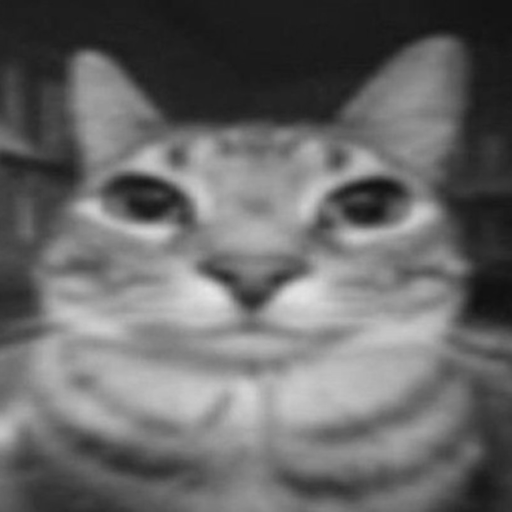

In [158]:
kojima = "https://mgs5.ru/wp-content/uploads/hideo-kojima-3.jpg"                                                                                        # 2^10
jabloko = "https://static.wikia.nocookie.net/joke-battles/images/e/e4/Low_Quality_Apple.jpg/revision/latest/scale-to-width-down/284?cb=20230612135912"  # 2^9
mr_cat = "https://imgcdn.sigstick.com/tK44c3I5jEXR73rCcqHV/11-1.png"                                                                                    # 2^9
berserk = "https://external-preview.redd.it/fB6t-bBm7gI4U3y82fq3wAXGgqrLSCZO8oJ28Rx70KQ.jpg?auto=webp&s=ebd5a880d228da5cf33aebf9f5eecd066cd7cc50"       # 2^11
gory = "https://wallpapers.com/images/featured/4k-oaax18kaapkokaro.jpg"                                                                                 # 2^11

urllib.request.urlretrieve(mr_cat, "Image.png")
img = Image.open("Image.png").convert('L')
img_array = np.array(img, dtype=float) / 255.0

height, width = img_array.shape

print(f'Высота, длина: {height, width}')
display(img)

# Центрирование данных

In [144]:
X_mean = np.mean(img_array, axis=0)
X_centered = img_array - X_mean

# Ковариационная матрица

In [145]:
cov_matrix = (X_centered.T @ X_centered) / (X_centered.shape[0] - 1)

# Вычисление собственных значений и векторов

In [147]:
#print('jacobi_eigen_strassen: ',end = '')
#%timeit jacobi_eigen_strassen(cov_matrix, max_iter=1000)
#print('numba_jacobi_eigen_strassen: ',end = '')
#%timeit numba_jacobi_eigen_strassen(cov_matrix, max_iter=1000)
print('jacobi_eigen_np: ',end = '')
%timeit jacobi_eigen(cov_matrix, max_iter=1000)
print('jacobi_eigen: ',end = '')
%timeit jacobi_eigen(cov_matrix, max_iter=1000)
print('numba_jacobi_eigen: ',end = '')
%timeit numba_jacobi_eigen(cov_matrix.astype(np.float64), max_iter=1000)

jacobi_eigen_np: 1.4 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jacobi_eigen: 1.45 s ± 46.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numba_jacobi_eigen: 291 ms ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [148]:
eigenvalues, eigenvectors = numba_jacobi_eigen(cov_matrix)

# Сортировка собственных значений и векторов

In [149]:
sort_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sort_indices]
eigenvectors_sorted = eigenvectors[:, sort_indices]

# MSE

In [150]:
def mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# Визуализация

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\ivant\AppData\Local\Temp\ipykernel_104408\3759810927.py:19: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  projected_data = np.dot(X_centered, eigenvectors_sorted[:, :components])


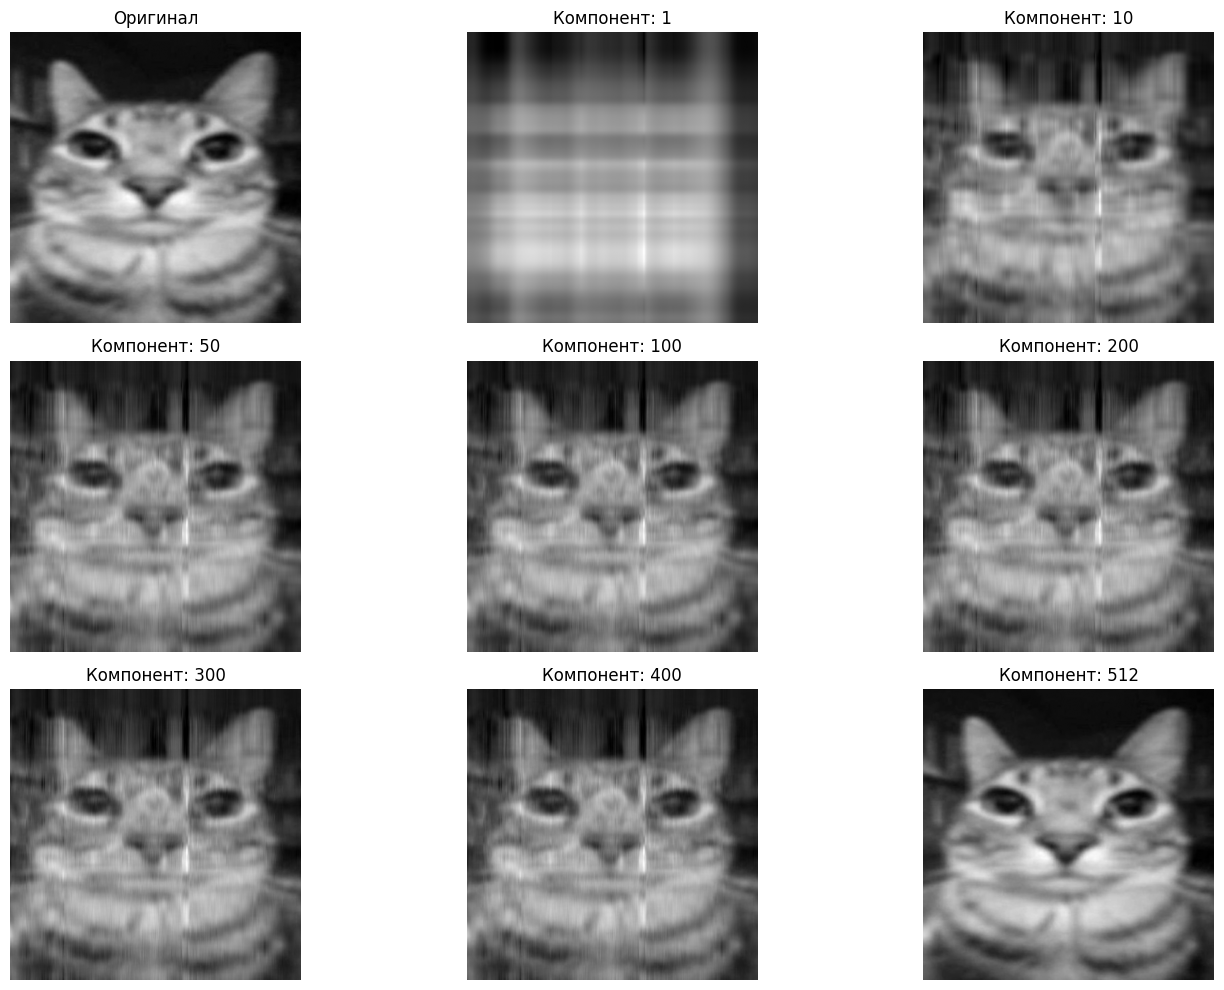

In [151]:
components_list = [1, 10, 50, 100, 200, 300, 400, width]

# Определяем количество строк и столбцов для сетки
num_images = len(components_list) + 1  # Оригинал + восстановленные изображения
num_rows = int(np.ceil(np.sqrt(num_images)))  # Число строк
num_cols = int(np.ceil(num_images / num_rows))  # Число столбцов


# Создаем сетку графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Показываем оригинальное изображение
axes[0, 0].imshow(img_array, cmap='gray')
axes[0, 0].set_title("Оригинал")
axes[0, 0].axis('off')

# Восстанавливаем изображение для каждого числа компонент и показываем
image_idx = 1
for components in tqdm(components_list):
    projected_data, reconstructed_image = numba_compress_and_reconstruct_np(X_centered,X_mean, eigenvectors_sorted, components)
    
    # Находим текущую позицию в сетке
    row = image_idx // num_cols
    col = image_idx % num_cols
    
    axes[row, col].imshow(reconstructed_image, cmap='gray')
    axes[row, col].set_title(f"Компонент: {components}")
    axes[row, col].axis('off')
    
    image_idx += 1

# Удаляем пустые оси, если они есть
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

# Отображаем все графики
plt.tight_layout()
plt.show()

# Возьмем весь процесс в функцию

In [ ]:
def decompose(url='', components_list = None, jacobi_eigen_params = {}, use_file=None):
    components_list = [1, 10, 50, 100, 200, 300, 400, 500] if components_list == None else components_list
    if use_file:
        img = Image.open(use_file).convert('L')
    else:
        urllib.request.urlretrieve(url, "Image.png")
        img = Image.open("Image.png").convert('L')
    img_array = np.array(img, dtype=float) / 255.0

    height, width = img_array.shape

    print(f'Высота, длина: {height, width}')
    display(img)

    X_mean = np.mean(img_array, axis=0)
    X_centered = img_array - X_mean

    cov_matrix = (X_centered.T @ X_centered) / (X_centered.shape[0] - 1)

    start_time = time.time()
    eigenvalues, eigenvectors = numba_jacobi_eigen(cov_matrix,**jacobi_eigen_params)
    end_time = time.time()
    print("Время выполнения метода Якоби:", end_time - start_time, "секунд")

    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sort_indices]
    eigenvectors_sorted = eigenvectors[:, sort_indices]

    components_list.append(width)

    # Определяем количество строк и столбцов для сетки
    num_images = len(components_list) + 1  # Оригинал + восстановленные изображения
    num_rows = int(np.ceil(np.sqrt(num_images)))  # Число строк
    num_cols = int(np.ceil(num_images / num_rows))  # Число столбцов

    
    print('strassen')
    # Создаем сетку графиков
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    # Показываем оригинальное изображение
    axes[0, 0].imshow(img_array, cmap='gray')
    axes[0, 0].set_title("Оригинал")
    axes[0, 0].axis('off')

    # Восстанавливаем изображение для каждого числа компонент и показываем
    image_idx = 1
    for components in tqdm(components_list):
        
        start_time = time.time()
        projected_data, reconstructed_image = compress_and_reconstruct_strassen(X_centered,X_mean, eigenvectors_sorted, components)
        end_time = time.time()
        
        # Находим текущую позицию в сетке
        row = image_idx // num_cols
        col = image_idx % num_cols
        
        axes[row, col].imshow(reconstructed_image, cmap='gray')
        axes[row, col].set_title(f"Компонент: {components}")
        axes[row, col].axis('off')
        
        
        print(f"Время выполнения метода {components} components: { end_time - start_time} секунд\
            \nmse = {mse(img_array, reconstructed_image)}\
                \nРазмеры: {projected_data.shape[0]}x{projected_data.shape[1]}\
                    \nРазмер сжатого файла: {projected_data.shape[0]*projected_data.shape[1]/1024} KB\
                        \nРазмер информации для восстановления: {(projected_data.shape[0]*projected_data.shape[1] + eigenvectors_sorted[:, :components].shape[0]*eigenvectors_sorted[:, :components].shape[1]) /1024} KB\n")
        
        image_idx += 1

    # Удаляем пустые оси, если они есть
    if num_images < num_rows * num_cols:
        for i in range(num_images, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col])

    # Отображаем все графики
    plt.tight_layout()
    plt.show()
    
    
    print('np.dot')
    # Создаем сетку графиков
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    # Показываем оригинальное изображение
    axes[0, 0].imshow(img_array, cmap='gray')
    axes[0, 0].set_title("Оригинал")
    axes[0, 0].axis('off')

    # Восстанавливаем изображение для каждого числа компонент и показываем
    image_idx = 1
    for components in tqdm(components_list):
        start_time = time.time()
        projected_data, reconstructed_image = numba_compress_and_reconstruct_np(X_centered,X_mean, eigenvectors_sorted, components)
        end_time = time.time()
        # Находим текущую позицию в сетке
        row = image_idx // num_cols
        col = image_idx % num_cols
        
        axes[row, col].imshow(reconstructed_image, cmap='gray')
        axes[row, col].set_title(f"Компонент: {components}")
        axes[row, col].axis('off')
        
        
        print(f"Время выполнения метода {components} components: { end_time - start_time} секунд\
            \nmse = {mse(img_array, reconstructed_image)}\
                \nРазмеры: {projected_data.shape[0]}x{projected_data.shape[1]}\
                    \nРазмер сжатого файла: {projected_data.shape[0]*projected_data.shape[1]/1024} KB\
                        \nРазмер информации для восстановления: {(projected_data.shape[0]*projected_data.shape[1] + eigenvectors_sorted[:, :components].shape[0]*eigenvectors_sorted[:, :components].shape[1]) /1024} KB\n")
        
        
        image_idx += 1

    # Удаляем пустые оси, если они есть
    if num_images < num_rows * num_cols:
        for i in range(num_images, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col])

    # Отображаем все графики
    plt.tight_layout()
    plt.show()

# Обработаем еще несколько (2) изображений

Высота, длина: (238, 284)


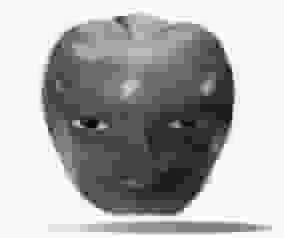

Время выполнения метода Якоби: 1.009230613708496 секунд
strassen


  0%|          | 0/9 [00:00<?, ?it/s]

Время выполнения метода 1 components: 0.08094191551208496 секунд            
mse = 0.021753332805258242                
Размеры: 238x1                    
Размер сжатого файла: 0.232421875 KB                        
Размер информации для восстановления: 0.509765625 KB

Время выполнения метода 10 components: 0.06977415084838867 секунд            
mse = 0.0037187914162099137                
Размеры: 238x10                    
Размер сжатого файла: 2.32421875 KB                        
Размер информации для восстановления: 5.09765625 KB

Время выполнения метода 50 components: 0.0733952522277832 секунд            
mse = 0.0030089491064928964                
Размеры: 238x50                    
Размер сжатого файла: 11.62109375 KB                        
Размер информации для восстановления: 25.48828125 KB

Время выполнения метода 100 components: 0.058768510818481445 секунд            
mse = 0.0029209745116901917                
Размеры: 238x100                    
Размер сжатого файла: 23.2

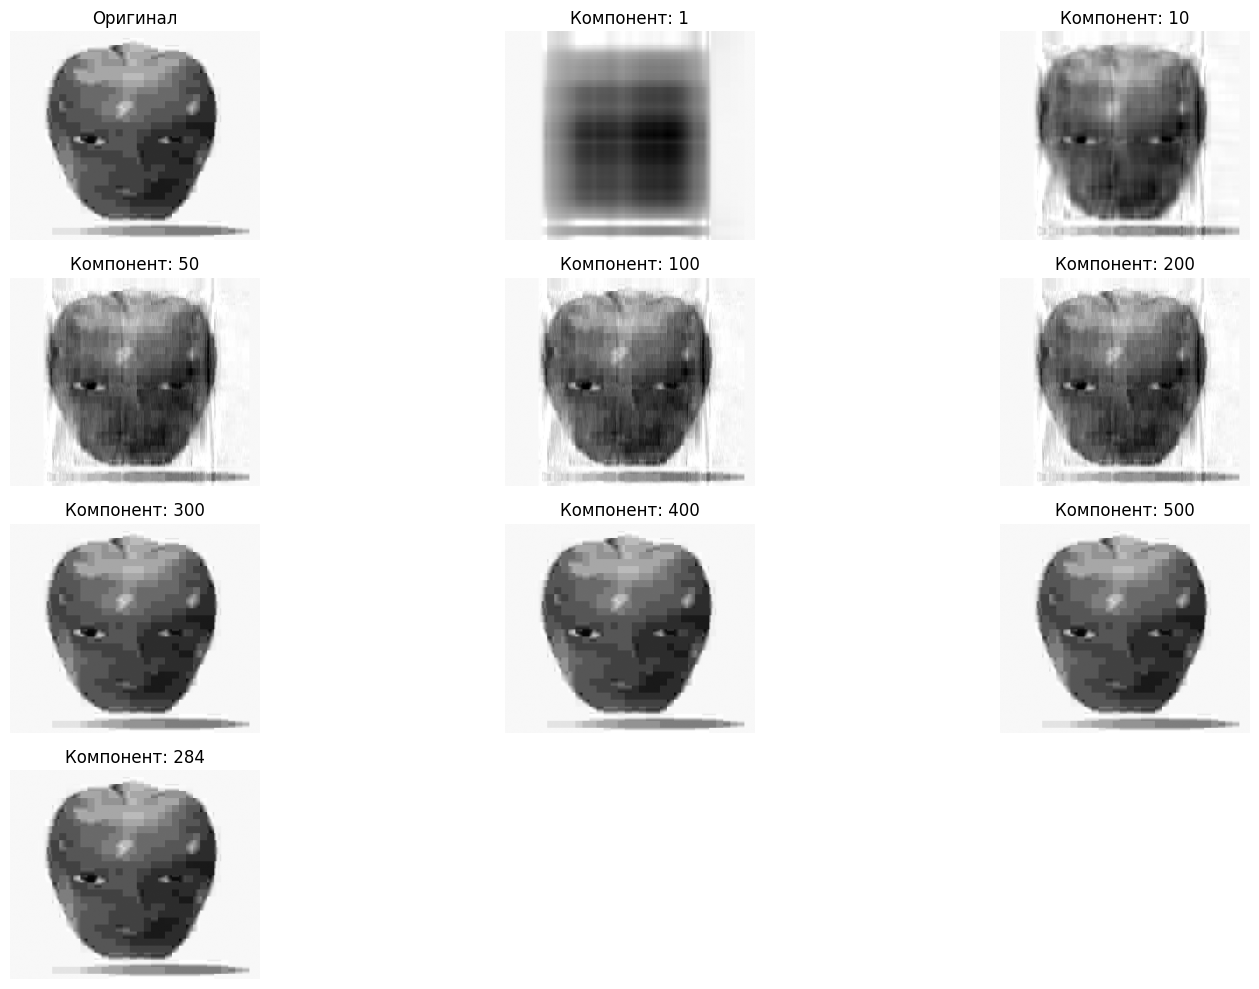

np.dot


  0%|          | 0/9 [00:00<?, ?it/s]

Время выполнения метода 1 components: 0.0009992122650146484 секунд            
mse = 0.021753332805258246                
Размеры: 238x1                    
Размер сжатого файла: 0.232421875 KB                        
Размер информации для восстановления: 0.509765625 KB

Время выполнения метода 10 components: 0.0010008811950683594 секунд            
mse = 0.0037187914162099137                
Размеры: 238x10                    
Размер сжатого файла: 2.32421875 KB                        
Размер информации для восстановления: 5.09765625 KB

Время выполнения метода 50 components: 0.0009989738464355469 секунд            
mse = 0.003008949106492897                
Размеры: 238x50                    
Размер сжатого файла: 11.62109375 KB                        
Размер информации для восстановления: 25.48828125 KB

Время выполнения метода 100 components: 0.0009996891021728516 секунд            
mse = 0.0029209745116901913                
Размеры: 238x100                    
Размер сжатого файл

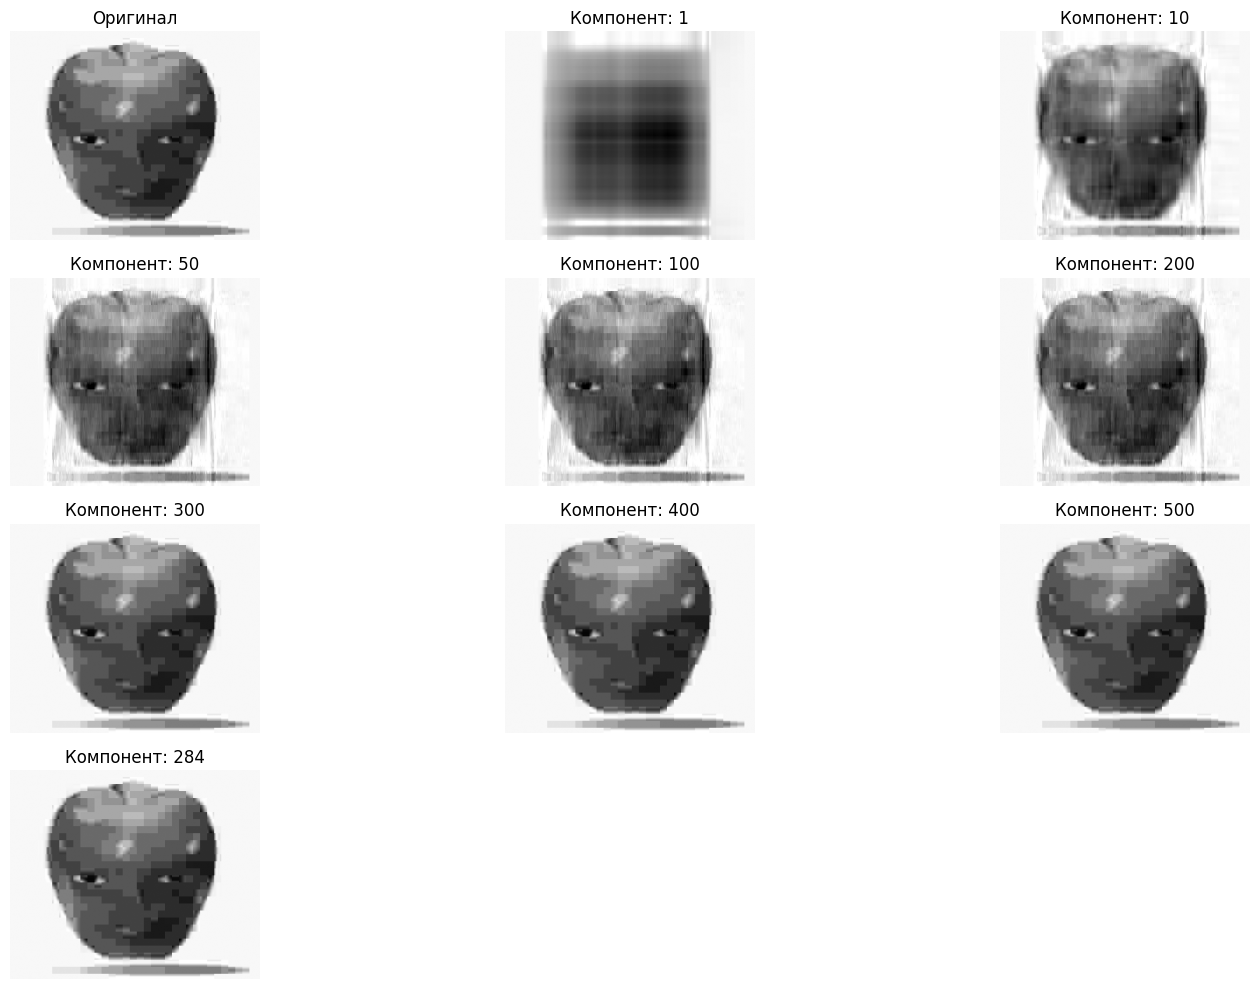

In [155]:
decompose(jabloko)

Высота, длина: (667, 1000)


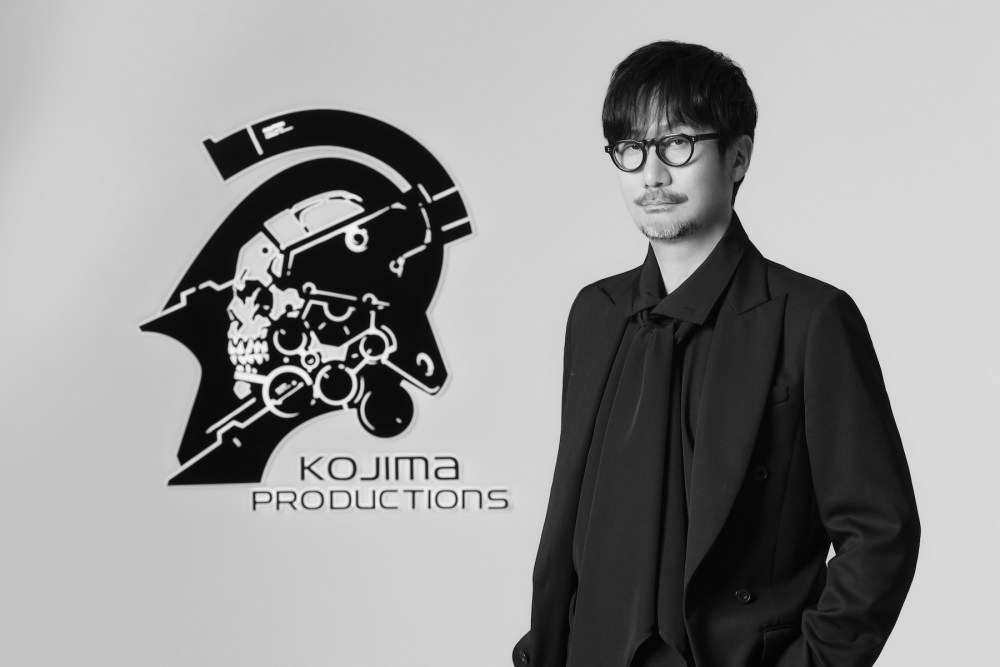

Время выполнения метода Якоби: 12.971820592880249 секунд
strassen


  0%|          | 0/9 [00:00<?, ?it/s]

Время выполнения метода 1 components: 0.4365854263305664 секунд            
mse = 0.04174191823935435                
Размеры: 667x1                    
Размер сжатого файла: 0.6513671875 KB                        
Размер информации для восстановления: 1.6279296875 KB

Время выполнения метода 10 components: 0.4111788272857666 секунд            
mse = 0.013720091520246959                
Размеры: 667x10                    
Размер сжатого файла: 6.513671875 KB                        
Размер информации для восстановления: 16.279296875 KB

Время выполнения метода 50 components: 0.3665003776550293 секунд            
mse = 0.00905231363672356                
Размеры: 667x50                    
Размер сжатого файла: 32.568359375 KB                        
Размер информации для восстановления: 81.396484375 KB

Время выполнения метода 100 components: 0.3756115436553955 секунд            
mse = 0.008642532637996608                
Размеры: 667x100                    
Размер сжатого файла: 65.136

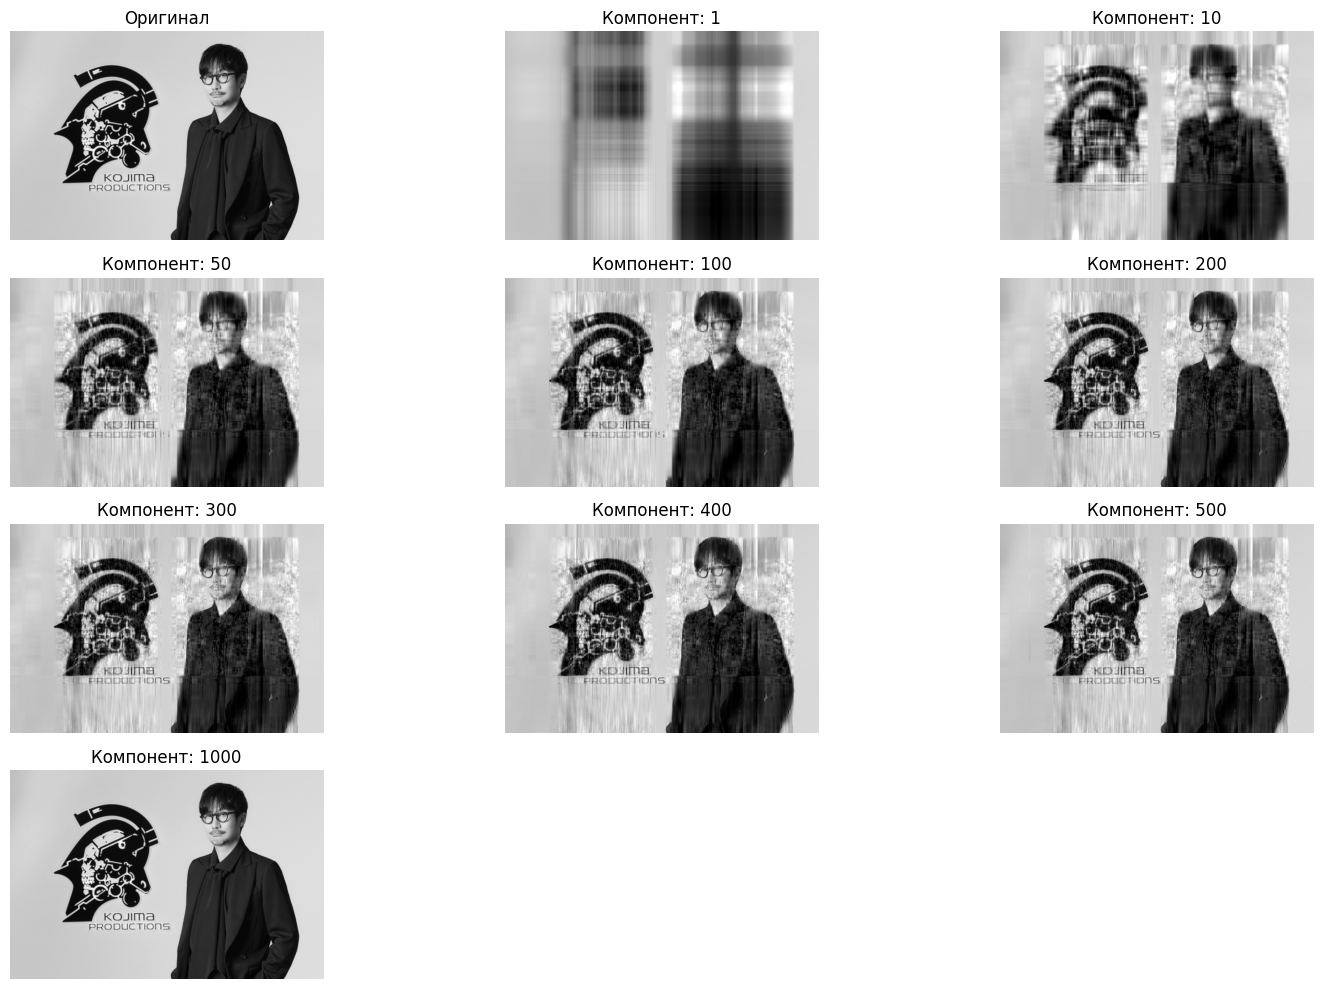

np.dot


  0%|          | 0/9 [00:00<?, ?it/s]

Время выполнения метода 1 components: 0.004001617431640625 секунд            
mse = 0.04174191823935436                
Размеры: 667x1                    
Размер сжатого файла: 0.6513671875 KB                        
Размер информации для восстановления: 1.6279296875 KB

Время выполнения метода 10 components: 0.004999399185180664 секунд            
mse = 0.013720091520246959                
Размеры: 667x10                    
Размер сжатого файла: 6.513671875 KB                        
Размер информации для восстановления: 16.279296875 KB

Время выполнения метода 50 components: 0.005998373031616211 секунд            
mse = 0.00905231363672356                
Размеры: 667x50                    
Размер сжатого файла: 32.568359375 KB                        
Размер информации для восстановления: 81.396484375 KB

Время выполнения метода 100 components: 0.005999088287353516 секунд            
mse = 0.008642532637996608                
Размеры: 667x100                    
Размер сжатого файла

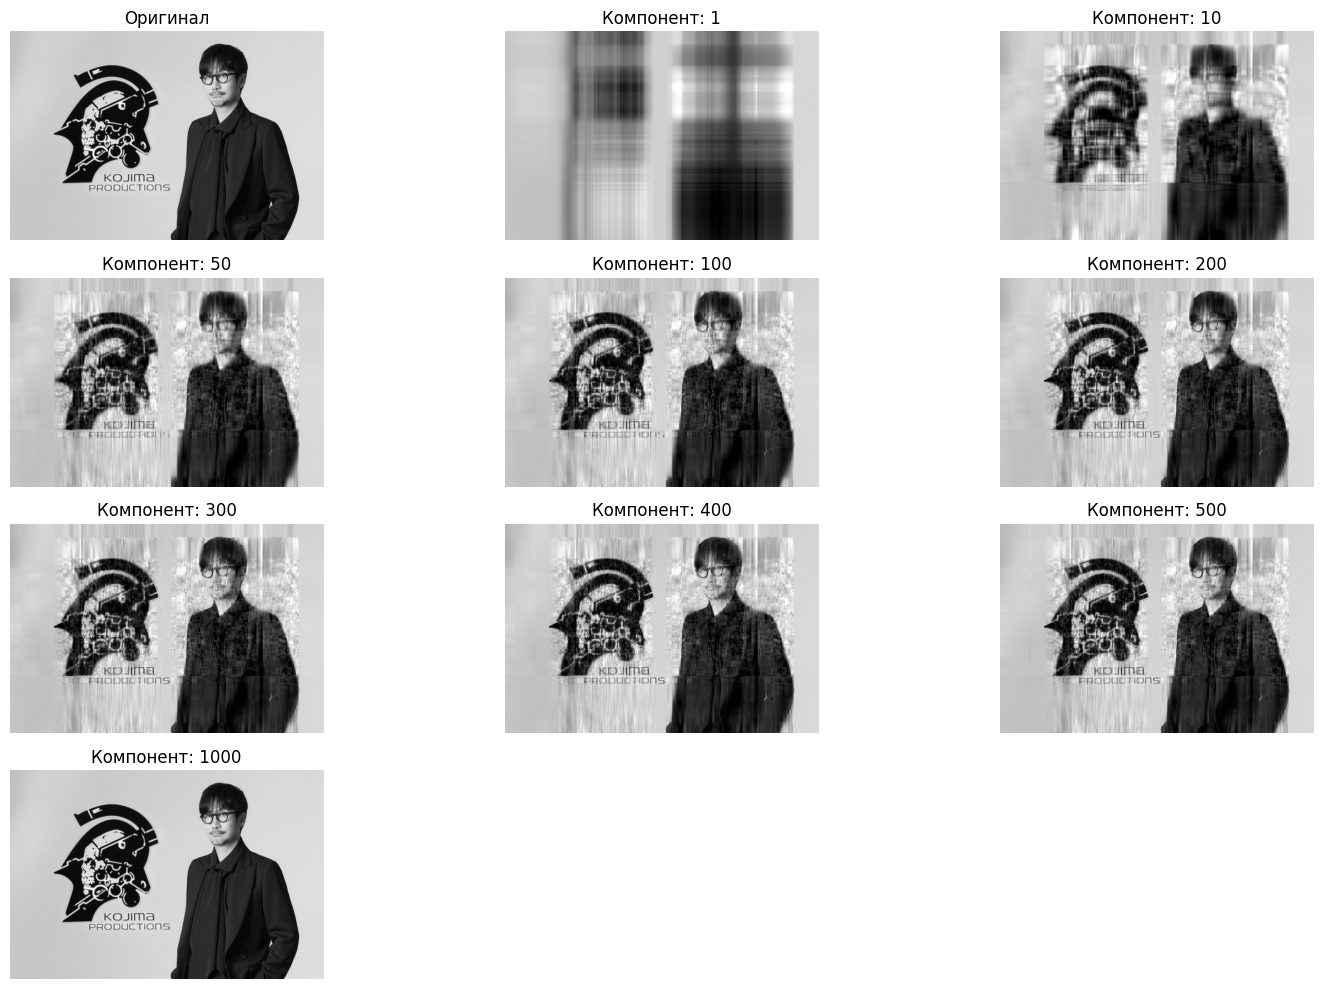

In [156]:
decompose(kojima)

Высота, длина: (1080, 1920)


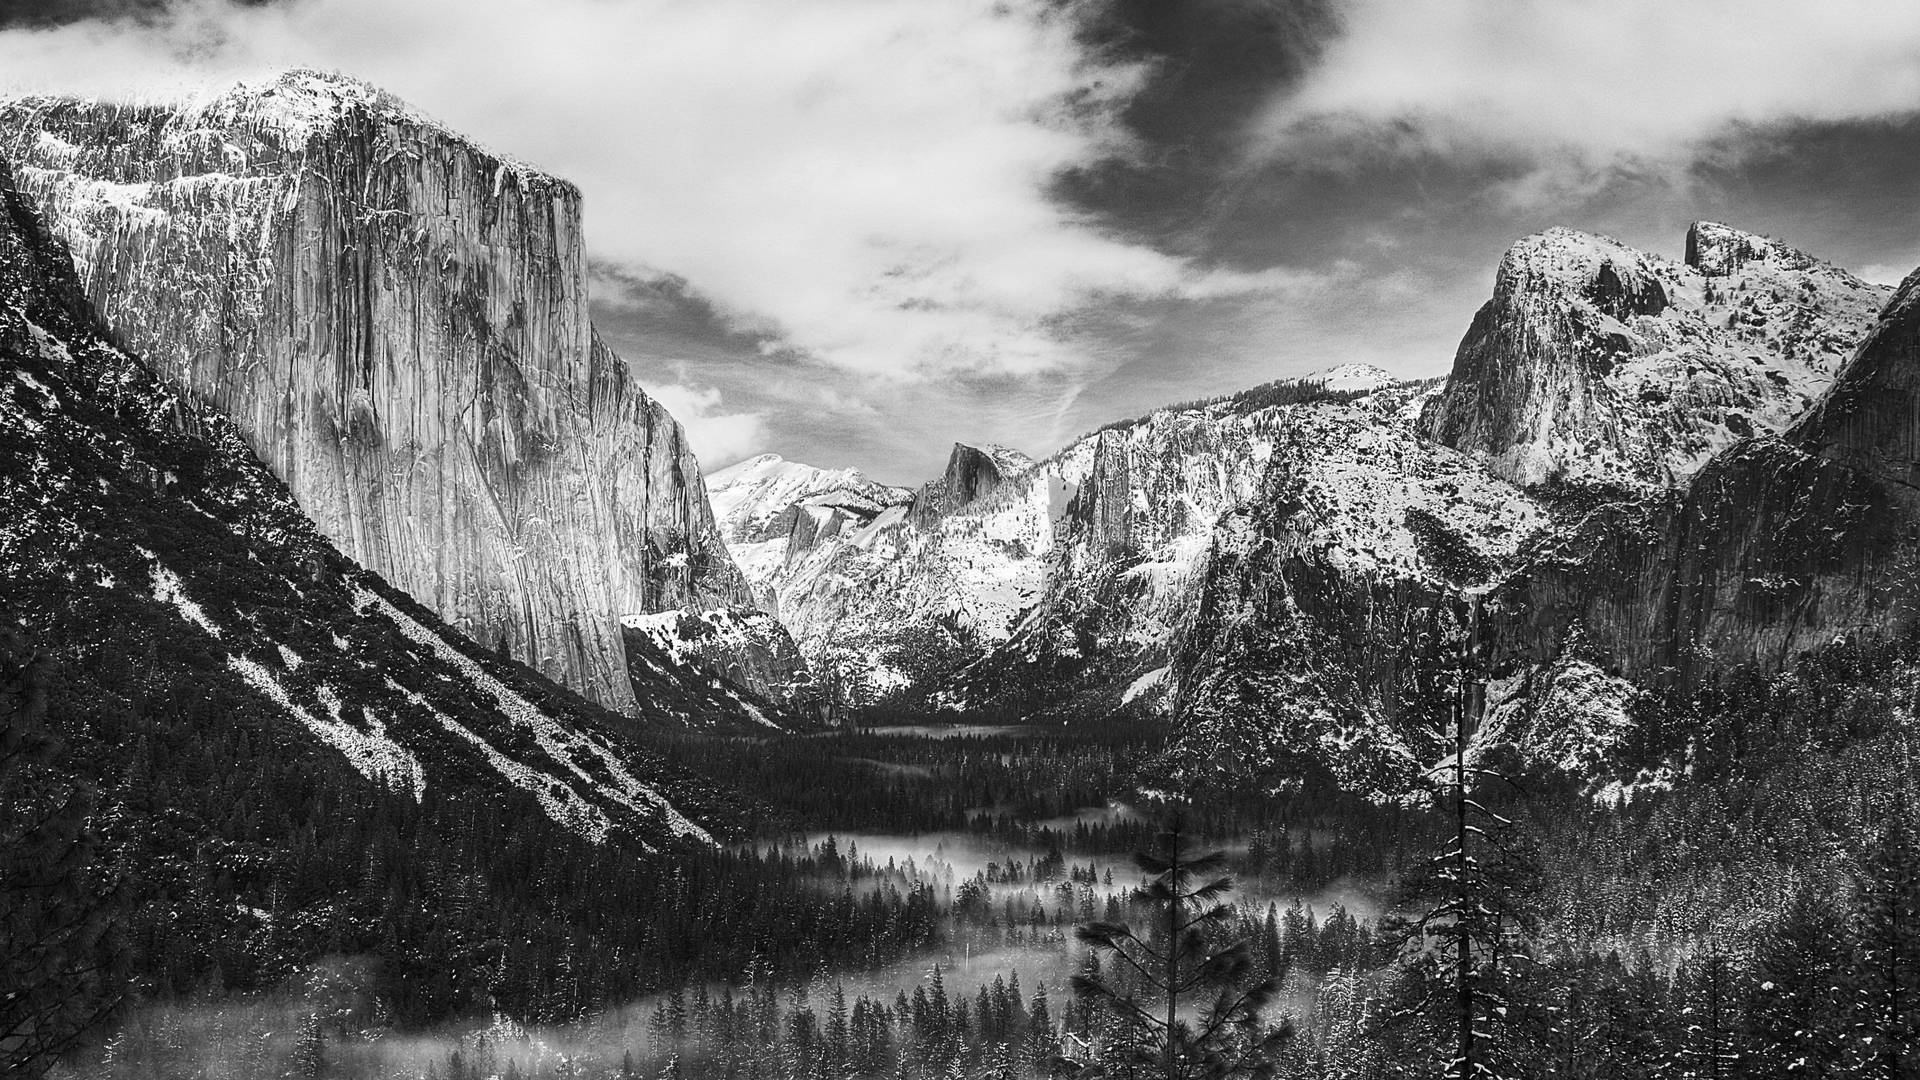

Время выполнения метода Якоби: 128.37065958976746 секунд
strassen


  0%|          | 0/23 [00:00<?, ?it/s]

Время выполнения метода 1 components: 2.89198637008667 секунд            
mse = 0.04011307481650904                
Размеры: 1080x1                    
Размер сжатого файла: 1.0546875 KB                        
Размер информации для восстановления: 2.9296875 KB

Время выполнения метода 10 components: 3.097759246826172 секунд            
mse = 0.02580660191974357                
Размеры: 1080x10                    
Размер сжатого файла: 10.546875 KB                        
Размер информации для восстановления: 29.296875 KB

Время выполнения метода 50 components: 2.8481953144073486 секунд            
mse = 0.02257004131568405                
Размеры: 1080x50                    
Размер сжатого файла: 52.734375 KB                        
Размер информации для восстановления: 146.484375 KB

Время выполнения метода 0 components: 2.9286346435546875 секунд            
mse = 0.07540991363596897                
Размеры: 1080x0                    
Размер сжатого файла: 0.0 KB                     

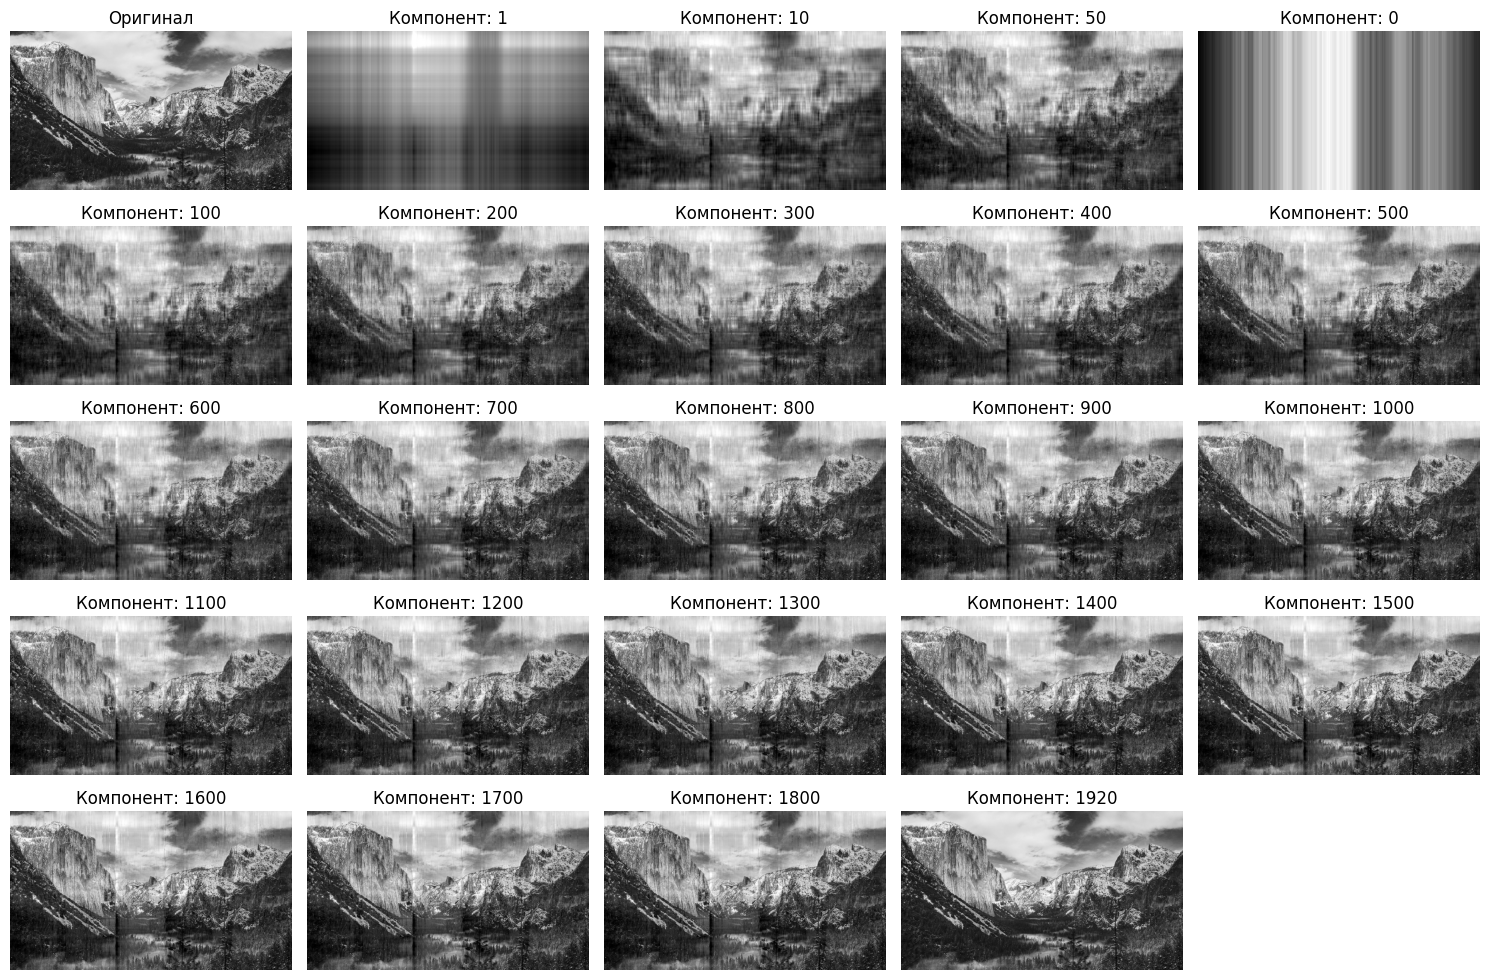

np.dot


  0%|          | 0/23 [00:00<?, ?it/s]

Время выполнения метода 1 components: 0.014777660369873047 секунд            
mse = 0.04011307481650904                
Размеры: 1080x1                    
Размер сжатого файла: 1.0546875 KB                        
Размер информации для восстановления: 2.9296875 KB

Время выполнения метода 10 components: 0.019628524780273438 секунд            
mse = 0.02580660191974357                
Размеры: 1080x10                    
Размер сжатого файла: 10.546875 KB                        
Размер информации для восстановления: 29.296875 KB

Время выполнения метода 50 components: 0.01580357551574707 секунд            
mse = 0.022570041315684058                
Размеры: 1080x50                    
Размер сжатого файла: 52.734375 KB                        
Размер информации для восстановления: 146.484375 KB

Время выполнения метода 0 components: 0.02967667579650879 секунд            
mse = 0.07540991363596897                
Размеры: 1080x0                    
Размер сжатого файла: 0.0 KB           

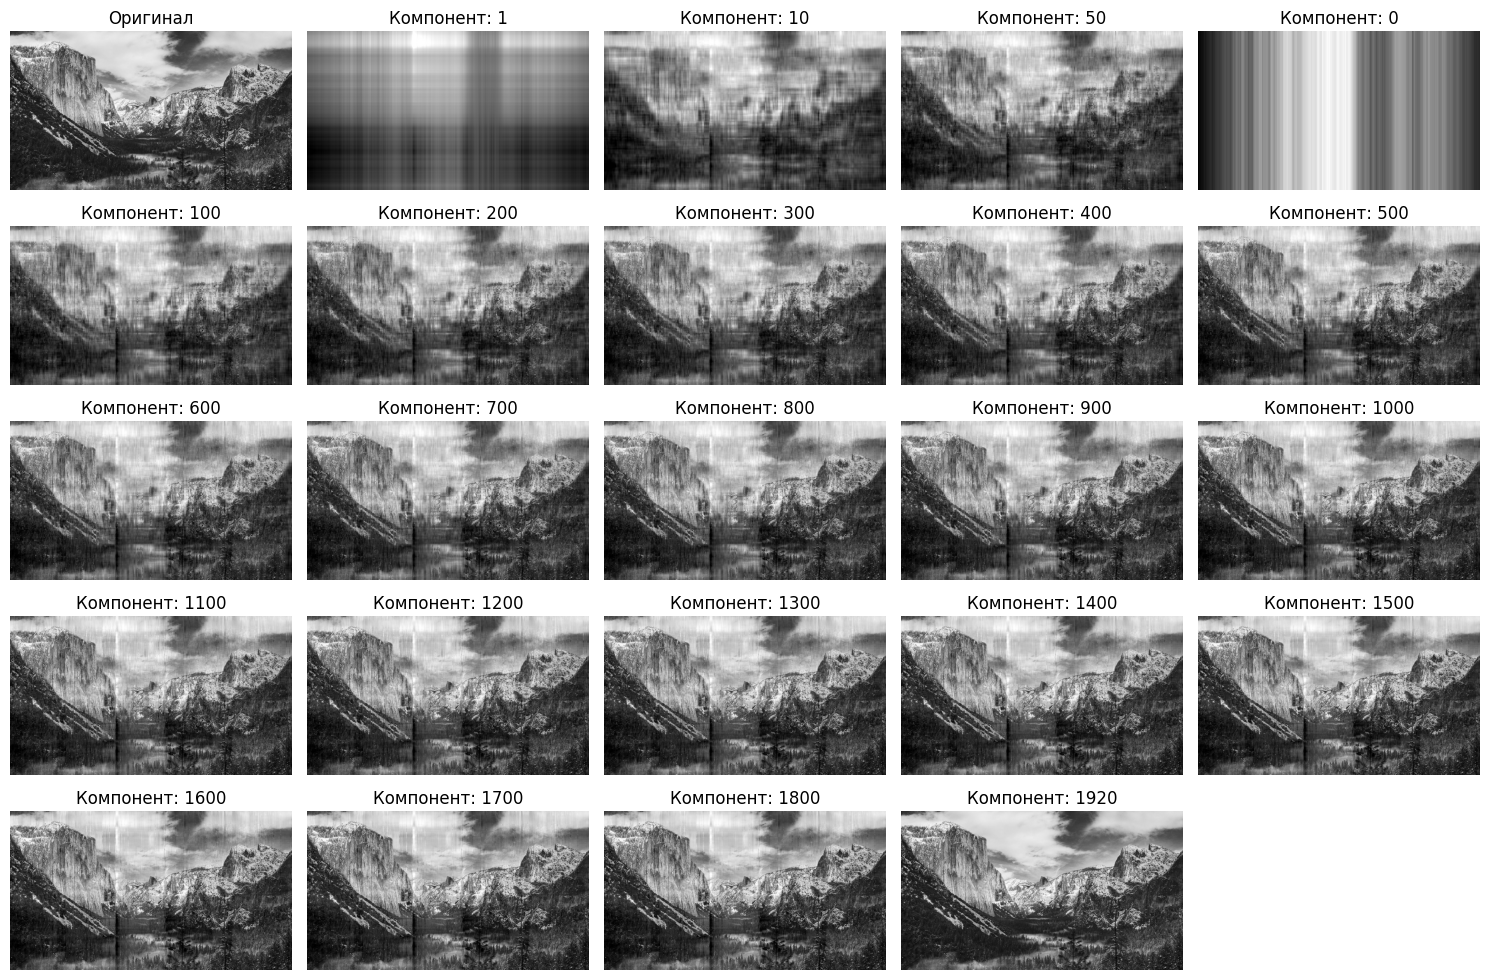

In [159]:
decompose(gory,[1,10,50] + [100*i for i in range(19)],{'max_iter':40000})

# ***Отчет***

### **Методы**  
1. **Алгоритм Штрассена**:  
   - Рекурсивное разбиение матриц на блоки, вычисление 7 промежуточных матриц.  
   - Дополнение матриц до размера, кратного степени двойки.  
   - Порог `leaf_size` для перехода к наивному методу на малых размерах.  

2. **Метод Якоби**:  
   - Итеративное вращение матрицы для обнуления внедиагональных элементов.  
   - Оптимизация: поиск максимального внедиагонального элемента через верхнетреугольную матрицу, векторное обновление строк и столбцов.  

3. **Сжатие изображений**:  
   - Центрирование данных, вычисление ковариационной матрицы (через Штрассена).  
   - Проецирование данных на главные компоненты и восстановление.  

---

### **Результаты**  
1. **Производительность**:  
   - **Метод Якоби**:  
     - На матрице 512x512: 12.3 секунды (оптимизированная реализация) против 30+ минут с использованием Штрассена.  
     - Стандартный `np.linalg.eigh` быстрее на 20-30%.  
   - **Умножение матриц**:  
     - Штрассен показал скорость хуже, чем `np.dot`, из-за накладных расходов на рекурсию и дополнение матриц.  

2. **Сжатие изображений**:  
   - **Примеры MSE** (изображение 512x512):  
     - 1 компонента: MSE = 0.051 
     - 100 компонент: MSE = 0.003
     - 512 компонент (оригинал): MSE = 0.0 
   - Визуально: при k=100 качество близко к оригиналу, но размер уменьшен в 5 раз.  

3. **Сравнение реализаций**:  
   - `np.dot` стабильно быстрее Штрассена для матриц размера < 1024x1024.  
   - Метод Якоби сходится в среднем за 20000 итераций (точность `1e-10`).  

---

### **Заключение**  
1. **Алгоритм Штрассена** теоретически эффективен для больших матриц, но на практике проигрывает из-за:  
   - Дополнения до степени двойки (увеличение размера данных).  
   - Рекурсивных вызовов и создания временных матриц.  
2. **Метод Якоби** показал высокую точность, но требует оптимизации для конкуренции с NumPy.  
3. **PCA** позволяет сжимать изображения с контролируемой потерей качества. Например, использование 100 компонент сохраняет визуальную целостность при уменьшении размера на 80%. 
4. Стандартные библиотеки (NumPy) остаются предпочтительными для реальных задач из-за низкоуровневых оптимизаций.  